<a href="https://colab.research.google.com/github/andrea-dai/deep_learning_nlp_find_the_similar_job/blob/main/Deep_learning_NLP_find_the_similar_job.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Use case: a company owns a job portal and has many job posts from other companies who wanna hire candidates. The company wants to have understanding of these job feeds in order to build a search engine. Your job is to do analysis on these data and feedback insights to the business 

#Imported packages

In [ ]:
import gensim
from gensim.models import Word2Vec

import re  # For preprocessing
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency

import spacy  # For preprocessing

import logging  # Setting up the loggings to monitor gensim
import pandas as pd

# nltk preprocessing magic
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from spacy.lang.de.examples import sentences 
import spacy.cli
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

from gensim.models.phrases import Phrases, Phraser

In [ ]:

url = 'https://drive.google.com/file/d/16EGubjXaeDwTH7sc6FnuQj7EI9ZfRYNL/view?usp=sharing' 
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
df = pd.read_csv(path, sep = '\t')

In [ ]:
df.columns

Index(['Unnamed: 0', 'job_title', 'full_description', 'company', 'location'], dtype='object')

In [ ]:
df = df[['job_title', 'full_description', 'company', 'location']]

In [ ]:
df['summary'] =  df['job_title'] + ' ' + df['full_description']
df['job_title_ori'] = df['job_title']
df['full_description_ori'] = df['full_description']

In [ ]:
df.head(5)

,job_title,full_description,company,location,summary,job_title_ori,full_description_ori
0,Senior Testmanager/Qualitätsmanager (m/w) Shif...,"Zum weiteren Ausbau unseres Teams, suchen wir ...",NTT DATA Deutschland GmbH,deutschlandweit,Senior Testmanager/Qualitätsmanager (m/w) Shif...,Senior Testmanager/Qualitätsmanager (m/w) Shif...,"Zum weiteren Ausbau unseres Teams, suchen wir ..."
1,Junior Java Entwickler (m/w) in spannenden Ent...,Erfahrungen im Umgang mit objektorientierten P...,NTT DATA Deutschland GmbH,"Frankfurt a.M., Köln, München, Stuttgart, deut...",Junior Java Entwickler (m/w) in spannenden Ent...,Junior Java Entwickler (m/w) in spannenden Ent...,Erfahrungen im Umgang mit objektorientierten P...
2,(Senior)Technical Consultant (m/w) Testautomat...,DBS-8346-SR - Einsatzort: deutschlandweit - Wi...,NTT DATA Deutschland GmbH,deutschlandweit,(Senior)Technical Consultant (m/w) Testautomat...,(Senior)Technical Consultant (m/w) Testautomat...,DBS-8346-SR - Einsatzort: deutschlandweit - Wi...
3,Einsteiger (w/m) Digitalisierung und Data Anal...,Die globale EY-Organisation* ist einer der Mar...,Ernst & Young GmbH Wirtschaftsprüfungsgesellsc...,Deutschlandweit,Einsteiger (w/m) Digitalisierung und Data Anal...,Einsteiger (w/m) Digitalisierung und Data Anal...,Die globale EY-Organisation* ist einer der Mar...
4,Projektmanager / Managing Consultant (m/w) Cus...,Idealerweise über drei Jahre praktische Erfahr...,NTT DATA Deutschland GmbH,"Frankfurt a.M., Köln, München, deutschlandweit",Projektmanager / Managing Consultant (m/w) Cus...,Projektmanager / Managing Consultant (m/w) Cus...,Idealerweise über drei Jahre praktische Erfahr...


#Data cleaning

In [ ]:
df.isnull().sum()

job_title               0
full_description        0
company                 0
location                0
summary                 0
job_title_ori           0
full_description_ori    0
dtype: int64

In [ ]:
df.shape


(23482, 7)

In [ ]:
!pip install unidecode
from unidecode import unidecode


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 235 kB 7.3 MB/s 


In [ ]:
df['job_title'] = df['job_title'].apply(unidecode)

In [ ]:
df['full_description'] = df['full_description'].apply(unidecode)

In [ ]:
df['summary'] = df['summary'].apply(unidecode)

In [ ]:
spacy.cli.download("de_core_news_sm")
nlp = spacy.load("de_core_news_sm")


✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')


In [ ]:
def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)

##Removes non-alphabetic characters:



In [ ]:
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df['job_title'])

In [ ]:
brief_cleaning_des = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df['full_description'])

In [ ]:
brief_cleaning_sum = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df['summary'])

Taking advantage of spaCy .pipe() attribute to speed-up the cleaning process:



In [ ]:
t = time()

txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000)]

print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))


Time to clean up everything: 0.47 mins


In [ ]:
t = time()

txt_des = [cleaning(doc) for doc in nlp.pipe(brief_cleaning_des, batch_size=5000)]

print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 1.04 mins


In [ ]:
t = time()

txt_sum = [cleaning(doc) for doc in nlp.pipe(brief_cleaning_sum, batch_size=5000)]

print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 1.07 mins


Put the results in a DataFrame to remove missing values and duplicates:



In [ ]:
df_clean = pd.DataFrame({'job_title': txt})
#df_clean = df_clean.dropna()
df_clean.shape

(23482, 1)

In [ ]:
df_clean

,job_title
0,Senior testmanag qualitatsmanag m w Shift left
1,Junior Java entwickl m w spannend Enterprise c...
2,Senior Technical Consultant m w Testautomati...
3,einsteig w m Digitalisierung Data Analytics fi...
4,projektmanag Managing Consultant m w Customer ...
...,...
23477,technisch Fachberater m w Innendienst
23478,Wirtschaftsingenieur Referent Vertrieb w m
23479,-- fachkraft m w
23480,Junior Projektingenieur Sensorik Kommunikati...


In [ ]:
df_clean_des = pd.DataFrame({'job_description': txt_des})
#df_clean_des = df_clean_des.dropna().drop_duplicates()
df_clean_des.shape

(23482, 1)

In [ ]:
df_clean_des

,job_description
0,Ausbau unser Team suchen test qualitatsmanag E...
1,Erfahrung Umgang objektorientiert Programmiers...
2,dbs sr einsatzort deutschlandweit Mitarbeiter ...
3,global ey Organisation Marktfuhrer Wirtschafts...
4,idealerweise uber praktisch Erfahrung berat Pr...
...,...
23477,kaufmannisch Bzw technisch Ausbildung kaufmann...
23478,deutsch Bahn wichtig Mobilitatsdienstleister g...
23479,Standort Heilbad Heiligenstadt thuring Unterne...
23480,Fur Unseren geschaftsbereich Verteidigung Sich...


In [ ]:
df_clean_sum = pd.DataFrame({'summary': txt_sum})
#df_clean_sum = df_clean_sum.dropna().drop_duplicates()
df_clean_sum.shape

(23482, 1)

In [ ]:
df_clean_sum

,summary
0,Senior testmanag qualitatsmanag m w Shift left...
1,Junior Java entwickl m w spannend Enterprise c...
2,Senior Technical Consultant m w Testautomati...
3,einsteig w m Digitalisierung Data Analytics fi...
4,projektmanag Managing Consultant m w Customer ...
...,...
23477,technisch Fachberater m w Innendienst kaufmann...
23478,Wirtschaftsingenieur Referent Vertrieb w m deu...
23479,-- fachkraft m w Standort Heilbad Heiligenstad...
23480,Junior Projektingenieur Sensorik Kommunikati...


####Bigrams


In [ ]:
df_clean = df.fillna(0)
df_clean_des.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23482 entries, 0 to 23481
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   job_description  23482 non-null  object
dtypes: object(1)
memory usage: 183.6+ KB


In [ ]:
sent = [row.split() for row in df_clean['job_title']]

In [ ]:
sent_des = [row.split() for row in df_clean_des['job_description']]

In [ ]:
sent_sum = [row.split() for row in df_clean_sum['summary']]

Creates the relevant phrases from the list of sentences:



In [ ]:
phrases = Phrases(sent, min_count=30, progress_per=10000)

In [ ]:
phrases_des = Phrases(sent_des, min_count=30, progress_per=10000)

In [ ]:
phrases_sum = Phrases(sent_sum, min_count=30, progress_per=10000)

In [ ]:
bigram = Phraser(phrases)
bigram_des = Phraser(phrases_des)
bigram_sum = Phraser(phrases_sum)



In [ ]:
sentences = bigram[sent]
sentences_des = bigram_des[sent_des]
sentences_sum = bigram_sum[sent_sum]


In [ ]:
word_freq = defaultdict(int)
for sent in sentences_des:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

32125

In [ ]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['m_w',
 'Fur',
 '--',
 'suchen',
 'Team',
 'Bereich',
 'fur',
 'Standort',
 'Software',
 'unser']

Add the three cleaned columns to the original DataFrame

In [ ]:
for i in range(len(sentences)):
  df['job_title'][i]= sentences[i]
df['job_title']

0        [Senior, Testmanager/Qualitatsmanager, (m/w), ...
1        [Junior, Java_Entwickler, (m/w), in, spannende...
2        [(Senior)Technical, Consultant, (m/w), Testaut...
3        [Einsteiger, (w/m), Digitalisierung, und, Data...
4        [Projektmanager, /, Managing, Consultant, (m/w...
                               ...                        
23477    [Technischer, Fachberater, (m/w), im, Innendie...
23478    [Wirtschaftsingenieur, als, Referent, im, Vert...
23479                                 [IT, Fachkraft, m/w]
23480    [(Junior), Projektingenieur, Sensorik, und, Ko...
23481    [Bauingenieur, Konstruktiver, Ingenieurbau, (w...
Name: job_title, Length: 23482, dtype: object

In [ ]:
for i in range(len(sentences_des)):
  df['full_description'][i]= sentences_des[i]
df['full_description']

0        [Ausbau, unser_Team, suchen, test, qualitatsma...
1        [Erfahrung, Umgang, objektorientiert, Programm...
2        [dbs, sr, einsatzort, deutschlandweit, Mitarbe...
3        [global, ey, Organisation, Marktfuhrer, Wirtsc...
4        [idealerweise, uber, praktisch_Erfahrung, bera...
                               ...                        
23477    [kaufmannisch, Bzw, technisch, Ausbildung, kau...
23478    [deutsch_Bahn, wichtig_Mobilitatsdienstleister...
23479    [Standort, Heilbad, Heiligenstadt, thuring, Un...
23480    [Fur, Unseren, geschaftsbereich, Verteidigung_...
23481    [deutsch_Bahn, wichtig_Mobilitatsdienstleister...
Name: full_description, Length: 23482, dtype: object

In [ ]:
for i in range(len(sentences_sum)):
  df['summary'][i]= sentences_sum[i]
df['summary']

0        [Senior, testmanag, qualitatsmanag, m, w, Shif...
1        [Junior, Java_entwickl, m, w, spannend, Enterp...
2        [Senior, Technical, Consultant, m, w, Testauto...
3        [einsteig, w, m, Digitalisierung, Data, Analyt...
4        [projektmanag, Managing, Consultant, m, w, Cus...
                               ...                        
23477    [technisch, Fachberater, m, w, Innendienst, ka...
23478    [Wirtschaftsingenieur, Referent, Vertrieb, w, ...
23479    [--, fachkraft, m, w, Standort, Heilbad, Heili...
23480    [Junior, Projektingenieur, Sensorik, Kommunika...
23481    [Bauingenieur, konstruktiver, ingenieurbau, w,...
Name: summary, Length: 23482, dtype: object

# **Create and train the model**

In [ ]:
import multiprocessing

from gensim.models import Word2Vec

In [ ]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer

In [ ]:
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

In [ ]:
#Building the Vocabulary Table
t = time()

w2v_model.build_vocab(sentences_des, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))


Time to build vocab: 0.02 mins


In [ ]:
# train the model
t = time()

w2v_model.train(sentences_des, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 0.66 mins


In [ ]:
w2v_model.init_sims(replace=True)

#Exploring the model

In [ ]:
df.head(5)

,job_title,full_description,company,location,summary,job_title_ori,full_description_ori
0,"[Senior, Testmanager/Qualitatsmanager, (m/w), ...","[Ausbau, unser_Team, suchen, test, qualitatsma...",NTT DATA Deutschland GmbH,deutschlandweit,"[Senior, testmanag, qualitatsmanag, m, w, Shif...",Senior Testmanager/Qualitätsmanager (m/w) Shif...,"Zum weiteren Ausbau unseres Teams, suchen wir ..."
1,"[Junior, Java_Entwickler, (m/w), in, spannende...","[Erfahrung, Umgang, objektorientiert, Programm...",NTT DATA Deutschland GmbH,"Frankfurt a.M., Köln, München, Stuttgart, deut...","[Junior, Java_entwickl, m, w, spannend, Enterp...",Junior Java Entwickler (m/w) in spannenden Ent...,Erfahrungen im Umgang mit objektorientierten P...
2,"[(Senior)Technical, Consultant, (m/w), Testaut...","[dbs, sr, einsatzort, deutschlandweit, Mitarbe...",NTT DATA Deutschland GmbH,deutschlandweit,"[Senior, Technical, Consultant, m, w, Testauto...",(Senior)Technical Consultant (m/w) Testautomat...,DBS-8346-SR - Einsatzort: deutschlandweit - Wi...
3,"[Einsteiger, (w/m), Digitalisierung, und, Data...","[global, ey, Organisation, Marktfuhrer, Wirtsc...",Ernst & Young GmbH Wirtschaftsprüfungsgesellsc...,Deutschlandweit,"[einsteig, w, m, Digitalisierung, Data, Analyt...",Einsteiger (w/m) Digitalisierung und Data Anal...,Die globale EY-Organisation* ist einer der Mar...
4,"[Projektmanager, /, Managing, Consultant, (m/w...","[idealerweise, uber, praktisch_Erfahrung, bera...",NTT DATA Deutschland GmbH,"Frankfurt a.M., Köln, München, deutschlandweit","[projektmanag, Managing, Consultant, m, w, Cus...",Projektmanager / Managing Consultant (m/w) Cus...,Idealerweise über drei Jahre praktische Erfahr...


In [ ]:
# exploring the model

# most similar
most_similar = w2v_model.wv.most_similar(positive=["Produktmanager"])
most_similar

[('eng_Abstimmung', 0.7948232293128967),
 ('interdisziplinar', 0.7651664018630981),
 ('Schnittstelle', 0.76458740234375),
 ('Produktmanagement', 0.7642700672149658),
 ('verantwortest', 0.7431138753890991),
 ('eng_Zusammenarbeit', 0.7393072247505188),
 ('Entwicklungs', 0.7383135557174683),
 ('wirken', 0.729166567325592),
 ('produktmanag', 0.727417528629303),
 ('massgeblich', 0.7161362171173096)]

In [ ]:
# exploring the model

# most similar
w2v_model.wv.most_similar(positive=["Kaufmann"])


[('Frau', 0.9195899963378906),
 ('steuerfachangestellt', 0.8877947330474854),
 ('Bilanzbuchhalter', 0.8618528842926025),
 ('kaufmannisch_Ausbildung', 0.8418560028076172),
 ('Assistent', 0.8370388150215149),
 ('sachbearbeit', 0.8066164255142212),
 ('Finanzbuchhaltung', 0.8048571348190308),
 ('abgeschlossen_Berufsausbildung', 0.8029452562332153),
 ('Sachbearbeiter', 0.7953627705574036),
 ('kaufmannisch', 0.7942764759063721)]

In [ ]:
# most different

w2v_model.wv.most_similar(negative=["Kaufmann"])

[('apps', 0.3599650263786316),
 ('Features', 0.31318503618240356),
 ('Multi', 0.3065321445465088),
 ('Plattform', 0.29228073358535767),
 ('Cloud', 0.27352431416511536),
 ('Big_Data', 0.2699638605117798),
 ('Apps', 0.2602357864379883),
 ('things', 0.25856998562812805),
 ('iot', 0.2563084363937378),
 ('designs', 0.2545885443687439)]

In [ ]:
# similarity of 2 words

w2v_model.wv.similarity("Kaufmann", 'Ausbildung')

0.7698909

In [ ]:
# doesnt match
w2v_model.wv.doesnt_match(['Kaufmann', 'Big_Data', 'Data'])

'Kaufmann'

In [ ]:
# Analogy difference
# Which word is to Kaufmann as Big_Data is to Data?

w2v_model.wv.most_similar(positive=["Kaufmann", "Big_Data"], negative=["Data"], topn=3)


[('kaufmannisch_Ausbildung', 0.6935285329818726),
 ('steuerfachangestellt', 0.6925408840179443),
 ('Frau', 0.6821253299713135)]

In [ ]:
df2 = df[df_clean_des['job_description'].str.contains("Kaufmann")]
df2

,job_title,full_description,company,location,summary,job_title_ori,full_description_ori
1086,"[Kaufmann, (m/w), als, Assistenz, (m/w), der, ...","[Verstarkung_unser, Team, suchen, Fur, Standor...",CHEFS CULINAR Süd GmbH & Co. KG,Zusmarshausen,"[Kaufmann, m, w, Assistenz, m, w, Niederlassun...",Kaufmann (m/w) als Assistenz (m/w) der Niederl...,Zur Verstärkung unseres Teams suchen wir für d...
2147,"[Immobilienverwalter, /-, kaufmann, (m/w)]","[Fur, Team, aalen, suchen, Vollzeit, n, immobi...",i Live Immobilienverwaltung GmbH,Aalen,"[immobilienverwalt, Kaufmann, m, w, fur, Team,...",Immobilienverwalter /- kaufmann (m/w),Für unser Team in Aalen suchen wir in Vollzeit...
2766,"[IT-, Administrator, (m/w)]","[suchen, Spater, --, Administrator, m_w, uber,...",Südpfalzwerkstatt gGmbH,Offenbach,"[--_administrator, m, w, suchen, Spater, --, A...",IT- Administrator (m/w),Wir suchen ab dem 01.09.2018 oder später einen...
3475,"[(Senior), Business, Consultant, Versicherunge...","[Fur, Unseren, geschaftsbereich, versicherungs...",FINCON Unternehmensberatung GmbH,"Berlin, Hamburg, Frankfurt am Main, Köln, Münc...","[Senior, Business, consultant, versicherung, m...",(Senior) Business Consultant Versicherungen (m/w),Für unseren Geschäftsbereich Versicherungswirt...
4604,"[IT-Administrator, (m/w)]","[abgeschlossen_Ausbildung, it, System, Kaufman...",ZAG Personal & Perspektiven,Heilbronn,"[--_administrator, m, w, abgeschlossen_Ausbild...",IT-Administrator (m/w),Abgeschlossene Ausbildung als IT-System-Kaufma...
5066,"[Sales, Manager, (m/w), fur, Key_Account]","[ingenieur, Maschinenbau, wirtschafts, ingenie...",Hauni Maschinenbau GmbH,Hamburg,"[sale_Manager, m, w, fur, Key, accounen, ingen...",Sales Manager (m/w) für Key Account,"Sie sind Ingenieur (Maschinenbau), Wirtschafts..."
5242,"[Vertriebsreprasentant, (m/w), Export]","[Studium, Ingenieur, m_w, Betriebswirt, m_w, b...",Bayka - Bayerische Kabelwerke AG,Roth bei Nürnberg,"[vertriebsreprasentant, m, w, export, Studium,...",Vertriebsrepräsentant (m/w) Export,Sie ein Studium als Ingenieur (m/w) oder Betri...
5684,"[Vice, President, Sales, and, Customer_Service...","[setzen, erfolgreich_abgeschlossen, Hochschuls...",Firma nicht bekannt gegeben,NRW,"[Vice, presidenen, sal, and, Customer_Service,...",Vice President Sales and Customer Service (m/w),Wir setzen ein erfolgreich abgeschlossenes Hoc...
7171,"[Einkaufer, /, Technischer, Einkaufer, (m/w)]","[Ausbildung, Studium, Kaufmann, Frau, technisc...",PROSOZ Herten GmbH,Herten (Ruhrgebiet),"[Einkaufer, technisch, Einkaufer, m, w, Ausbil...",Einkäufer / Technischer Einkäufer (m/w),Ausbildung oder Studium als Kaufmann/-frau mit...
7480,"[vertriebsorientierter, kaufmannischer, Mitarb...","[Verstarkung_unser, Team, suchen, Fur, Stunde,...",CHEFS CULINAR Nord-Ost GmbH & Co. KG,Großbeeren,"[vertriebsorientiert, kaufmannisch, Mitarbeite...",vertriebsorientierter kaufmännischer Mitarbeit...,Zur Verstärkung unseres Teams suchen wir für 3...


In [ ]:
!pip install polyfuzz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.2 MB 11.6 MB/s 


In [ ]:
len(df_clean_des)

23482

In [ ]:
most_similar = [i[0] for i in most_similar]
most_similar

['eng_Abstimmung',
 'interdisziplinar',
 'Schnittstelle',
 'Produktmanagement',
 'verantwortest',
 'eng_Zusammenarbeit',
 'Entwicklungs',
 'wirken',
 'produktmanag',
 'massgeblich']

In [ ]:
from polyfuzz.models import TFIDF
from polyfuzz import PolyFuzz

to_list = most_similar
from_list = df_clean_des['job_description'].values.tolist()

tfidf = TFIDF(n_gram_range=(3, 3))
model_polyfuzz = PolyFuzz(tfidf)
model_polyfuzz.match(from_list, to_list)


df_matches = model_polyfuzz .get_matches()
df_matches = df_matches.sort_values(by=['Similarity'], ascending=False)

df_matches

,From,To,Similarity
15415,Verstarkung Abteilung Produktmanagement suchen...,Produktmanagement,0.704
17029,unser digital Produktmanagement Team Head of P...,Produktmanagement,0.702
16109,mindestens relevant Berufserfahrung Produktman...,Produktmanagement,0.693
15858,suchen Fur unser Standort dusseldorf it Produk...,produktmanag,0.679
17112,Fur Team suchen Koln junior produktmanag m w B...,Produktmanagement,0.677
...,...,...,...
3774,Mail Pdf be Part -- our global Team Mckesson e...,None,0.000
4933,rwe Supply trading -- leading European energy ...,None,0.000
13727,abbvie Nyse abbv -- global research based biop...,None,0.000
8741,konzept handch Fur design Designer handch fur ...,None,0.000


#Visualizations

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")
import re  # For preprocessing
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency

To make the visualizations more relevant, we will look at the relationships between a query word (in **red**), its most similar words in the model (in **blue**), and other words from the vocabulary (in **green**).

In [ ]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']
    # adds the vector of the query word
    arrays = np.append(arrays, model.__getitem__([word]), axis=0)
    # gets list of most similar words
    close_words = model.most_similar([word])
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)

    # Reduces the dimensionality from 300 to 21 dimensions with PCA
    reduc = PCA(n_components=21).fit_transform(arrays)

    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))
    


##10 Most similar words vs. 10 Most dissimilar

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: Call to deprecated `_

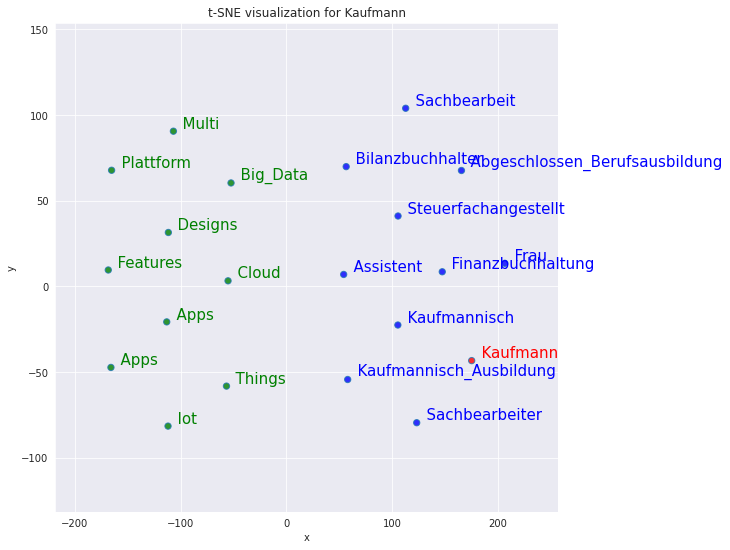

In [ ]:
tsnescatterplot(w2v_model, 'Kaufmann', [i[0] for i in w2v_model.most_similar(negative=["Kaufmann"])])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: Call to deprecated `_

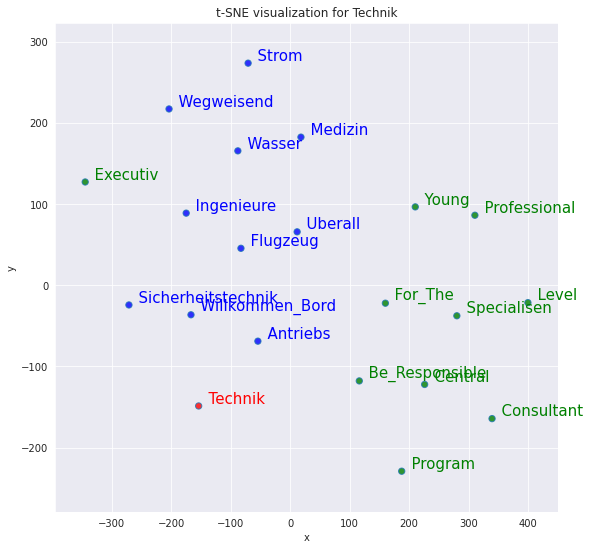

In [ ]:
tsnescatterplot(w2v_model, 'Technik', [i[0] for i in w2v_model.most_similar(negative=["Technik"])])

##10 Most similar words vs. 11th to 20th Most similar words:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: Call to deprecated `_

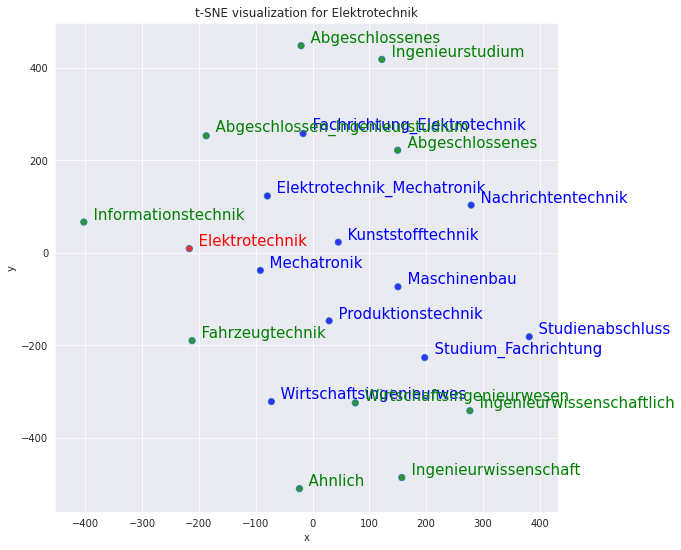

In [ ]:
tsnescatterplot(w2v_model, "Elektrotechnik", [t[0] for t in w2v_model.most_similar(positive=["Elektrotechnik"], topn=20)][10:])

##10 Most similar words vs. 10 Most dissimilar

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: Call to deprecated `_

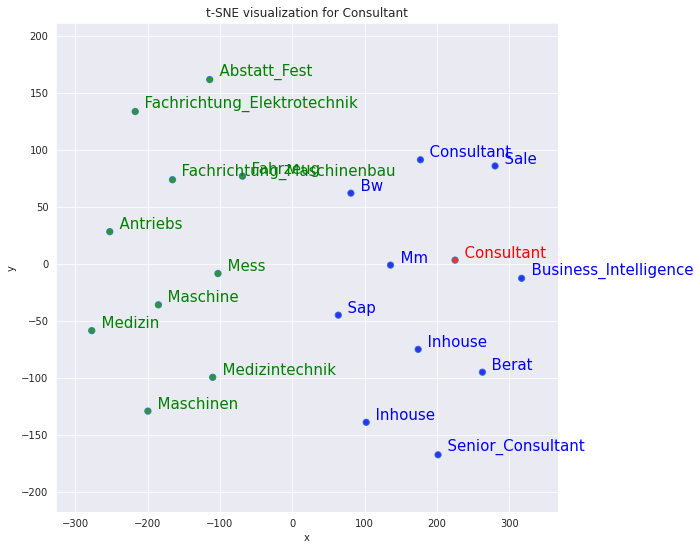

In [ ]:
tsnescatterplot(w2v_model, 'Consultant', [i[0] for i in w2v_model.most_similar(negative=["Consultant"])])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: Call to deprecated `_

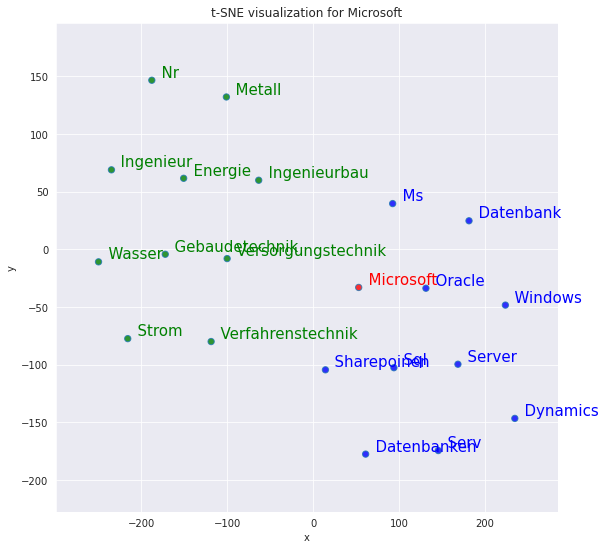

In [ ]:
tsnescatterplot(w2v_model, 'Microsoft', [i[0] for i in w2v_model.most_similar(negative=["Microsoft"])])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: Call to deprecated `_

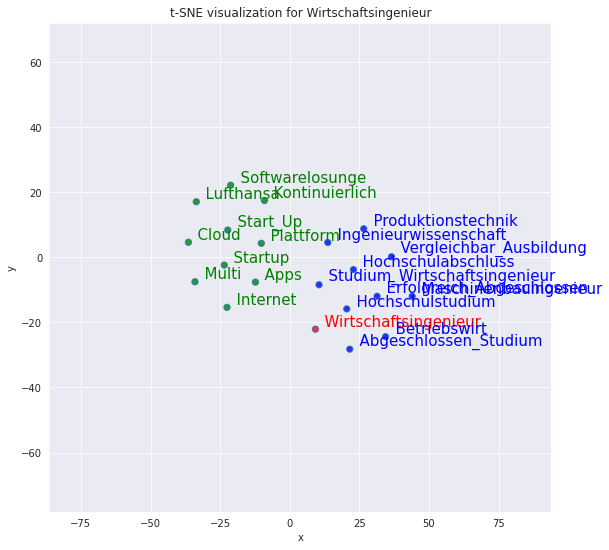

In [ ]:
tsnescatterplot(w2v_model, 'Wirtschaftsingenieur', [i[0] for i in w2v_model.most_similar(negative=["Wirtschaftsingenieur"])])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: Call to deprecated `_

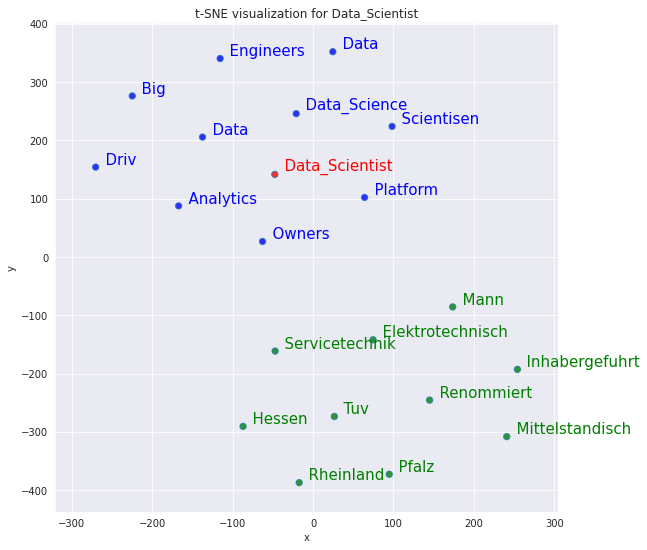

In [ ]:
tsnescatterplot(w2v_model, 'Data_Scientist', [i[0] for i in w2v_model.most_similar(negative=["Data_Scientist"])])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: Call to deprecated `_

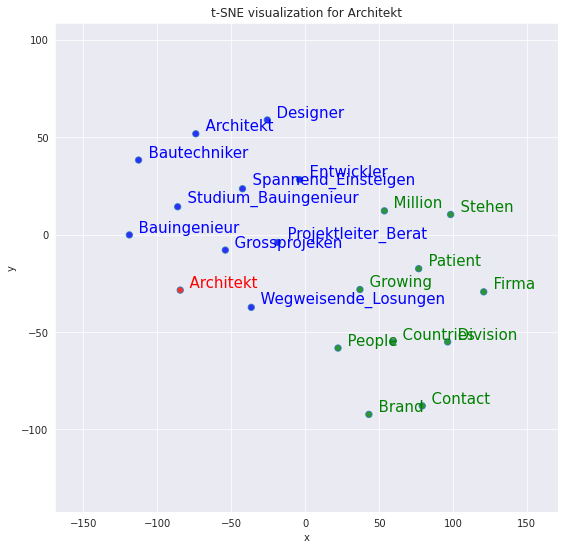

In [ ]:
tsnescatterplot(w2v_model, 'Architekt', [i[0] for i in w2v_model.most_similar(negative=["Architekt"])])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: Call to deprecated `_

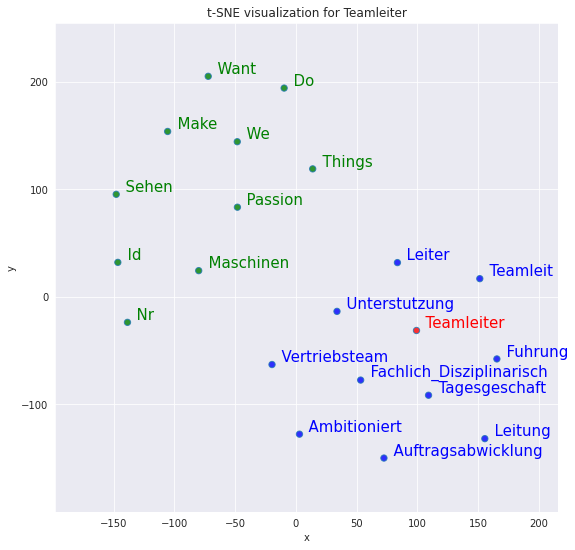

In [ ]:
tsnescatterplot(w2v_model, 'Teamleiter', [i[0] for i in w2v_model.most_similar(negative=["Teamleiter"])])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: Call to deprecated `_

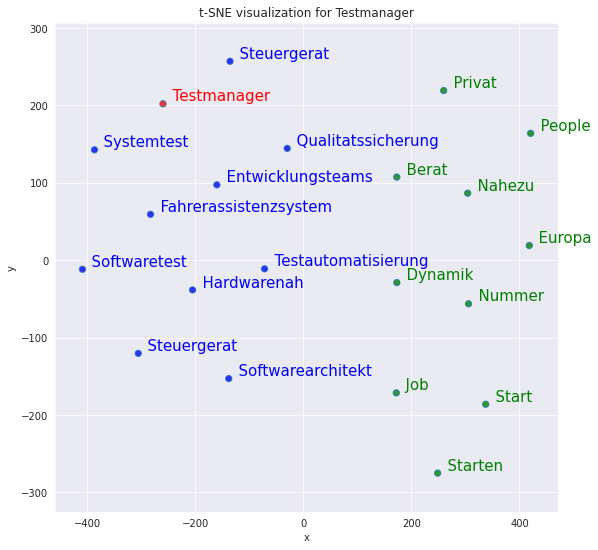

In [ ]:
tsnescatterplot(w2v_model, 'Testmanager', [i[0] for i in w2v_model.most_similar(negative=["Testmanager"])])


#Word Cloud

In [ ]:
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt



In [ ]:
# Start with one review:
text_wc = ' '.join(np.concatenate(df.full_description))

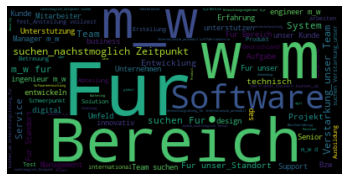

In [ ]:

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text_wc)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

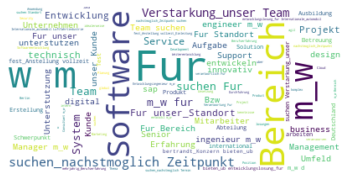

In [ ]:
# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text_wc)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()